In [1]:
import numpy as np
import pandas as pd 

import cv2 
# OpenCV library for computer vision tasks
import os 
# allowing you to access files, directories
from tqdm import tqdm 
# adds progress bars to loops, making it easier to track the progress of lengthy operations
from glob import glob 
# finds files and directories based on specific patterns

from keras.utils import to_categorical
# converts a class vector (integers) into binary class matrix
from sklearn.model_selection import train_test_split
# for splitting data into training and testing sets
import matplotlib.pyplot as plt
# plotting library that for creating visualizations
import matplotlib.image as mpimg
#image reading and manipulation capabilities for use with matplotlib

from keras.preprocessing.image import ImageDataGenerator
# for generating augmented data by applying various transformations to input images
from keras.models import Sequential, Model
# creating and configuring neural network models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
# layers used for building cnn

from keras.applications.vgg16 import VGG16
# A pre-trained convolutional neural network architecture for image classification tasks.

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv('state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)

# subject :- It refers to driver id
# classname :- this is the classification tag, corresponding to a particular image

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [3]:
# Groupby subjects
by_drivers = df.groupby('subject') 

#Group unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id

print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(df.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [4]:
num_classes = 10 # number of classes

# The 10 classes to classify are :

# c0: safe driving
# c1: texting - right
# c2: talking on the phone - right
# c3: texting - left
# c4: talking on the phone - left
# c5: operating the radio
# c6: drinking
# c7: reaching behind
# c8: hair and makeup
# c9: talking to passenger

In [5]:
#Read with opencv
def get_image(path, img_rows, img_cols, color_type=3):
    
    # reads an image file located at path, converts it to grayscale or color based on the color_type parameter
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    
    # resizes the image to the specified dimensions
    img = cv2.resize(img, (img_rows, img_cols))
    
    # returns the resized image
    return img

# train_data_load() function loads the training images for a distracted driver detection task, 
# preprocesses them using the get_image() function, and 
# stores them in a list called train_images.

def train_data_load(img_rows=64, img_cols=64, color_type=3):
    
    train_images=[] # contains preprocessed image
    train_labels=[] # contains corresponding class of the image at same index in train_images
    
    #Loop over the training folder, preprocesses images and add them to the list
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes)) # it prints a message indicating the directory being loaded
        
        files = glob(os.path.join('state-farm-distracted-driver-detection/imgs/train/c' + str(classes), '*.jpg'))
        # retrieve all the image files in the directory mentioned in the path
        
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            # read and preprocess the image using the specified dimensions and color type
            train_images.append(img)
            train_labels.append(classes)
    
    return train_images, train_labels

# function loads the training data and labels, 
# performs one-hot encoding on the labels, 
# splits the data into training and testing sets, 
# converts the data to NumPy arrays, and 
# returns the normalized training and testing data along with their corresponding labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    
    X, labels = train_data_load(img_rows, img_cols, color_type)
    #load the training data and labels
    
    y = to_categorical(labels, 10)
    #convert the numerical labels to one-hot encoded vectors
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    # convert x_train and x_test to NumPy arrays, with the data type set to np.uint8 (unsigned 8-bit integers). 
    # The arrays are reshaped to have dimensions of (-1, img_rows, img_cols, color_type), 
    # where -1 indicates that the size of that dimension is inferred based on the other dimensions.
    
    return x_train, x_test, y_train, y_test

#Loading validation dataset
# same as train_data_load()
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    
    # size refers to the test dataset size to be considered
    
    X_test = []
    X_test_id = []
    
    path = os.path.join('state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    files = sorted(glob(path))
    total = 0
    
    files_size = len(files)
    
    for file in tqdm(files):
        
        if total >= size or total >= files_size:
            break
        # if the number of images equals the size mentioned or the size of the file from which images are taken
        
        file_base = os.path.basename(file)
        img = get_image(file, img_rows, img_cols, color_type)
        # read and preprocess the image using the specified dimensions and color type
        
        X_test.append(img)
        X_test_id.append(file_base)
         
        total += 1
        # counts the number of images added
        
    return X_test, X_test_id

# function loads the sampled test/validation data and their IDs, 
# converts the data to NumPy arrays, 
# reshapes the data to the specified dimensions, and 
# returns the normalized test/validation data along with their corresponding IDs. 
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids
    

In [6]:
# defines the number of pixels in rows and columns in the preprocessed images
img_rows = 64
img_cols = 64
color_type = 3 # 1 means grayscaled and 3 means colour images

nb_test_samples = 2000
# number of test case samples

#Loading train images 
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

#Loading validation images 
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|████████▎                                                                          | 1/10 [00:13<01:59, 13.30s/it]

Loading directory c1


 20%|████████████████▌                                                                  | 2/10 [00:21<01:24, 10.58s/it]

Loading directory c2


 30%|████████████████████████▉                                                          | 3/10 [00:30<01:08,  9.80s/it]

Loading directory c3


 40%|█████████████████████████████████▏                                                 | 4/10 [00:39<00:56,  9.45s/it]

Loading directory c4


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:49<00:47,  9.44s/it]

Loading directory c5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:59<00:38,  9.59s/it]

Loading directory c6


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:08<00:28,  9.46s/it]

Loading directory c7


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:16<00:17,  8.95s/it]

Loading directory c8


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:23<00:08,  8.47s/it]

Loading directory c9


  3%|█▉                                                                          | 2000/79726 [00:08<05:30, 235.08it/s]


<div id="overview">
        <h1 style="color:#1a1a1a">
         ⮞  Part 2 : EDA 
        </h1>
</div>

### Data visualisation
 

In [7]:
import plotly.express as px
px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

# comparison of number of samples for each class in the training dataset


In [8]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())

drivers_id.columns = ['driver_id', 'Counts']

px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

### Images overview


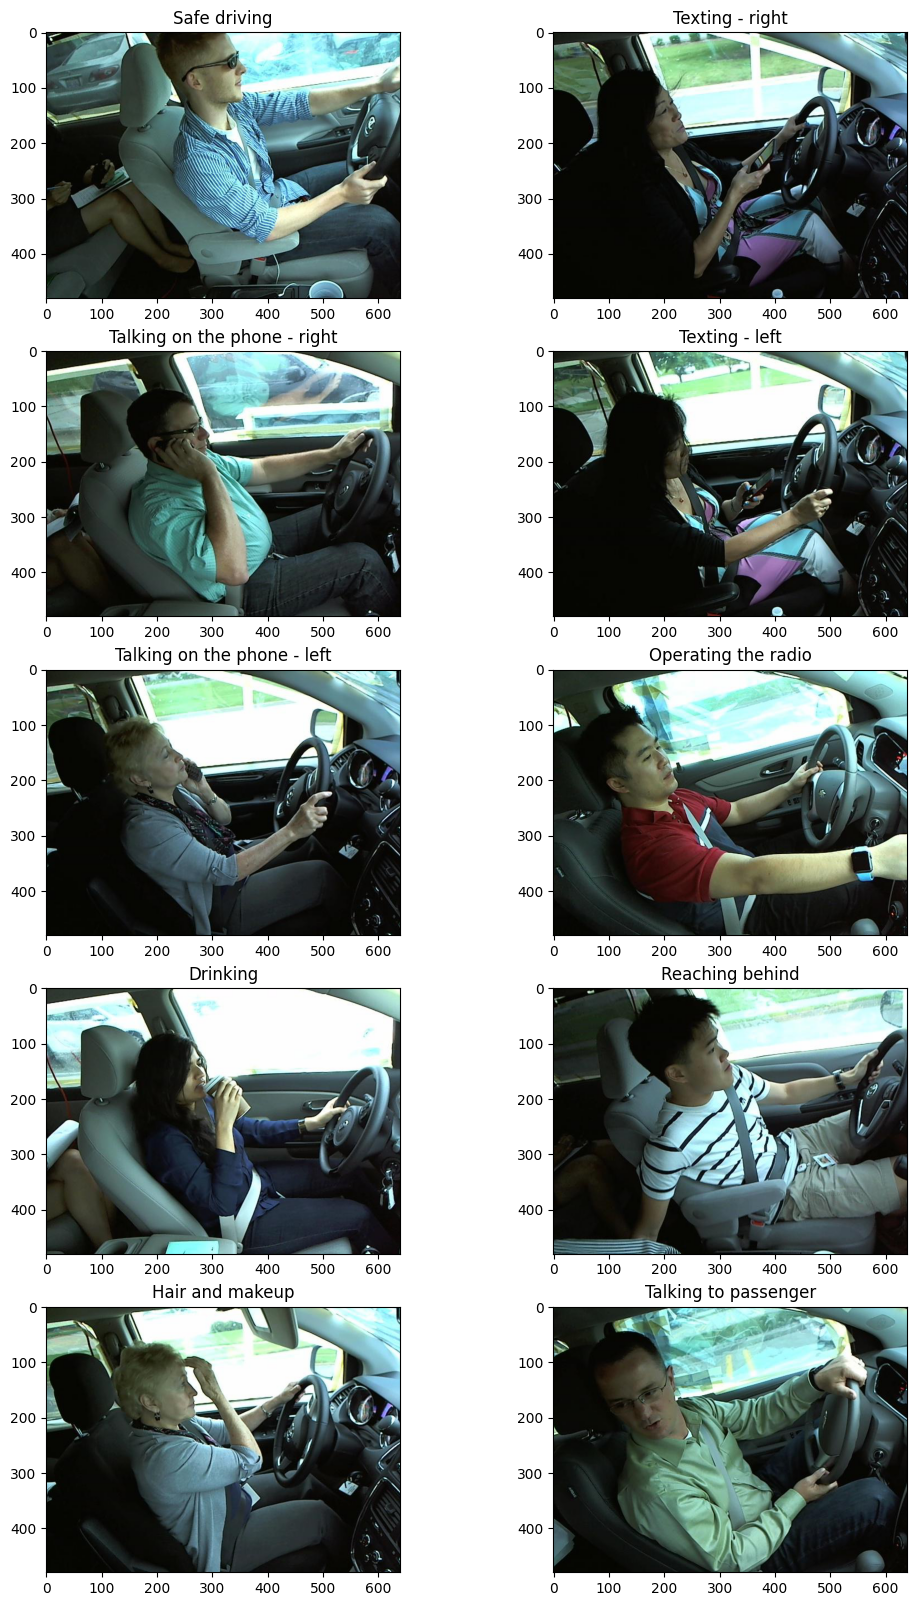

In [82]:
# displaying 1 image of each class as a sample

activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20)) # defining size of each image
image_count = 1
BASE_URL = 'state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

<div id="overview">
        <h1 style="color:#1a1a1a">
         ⮞  Part 3 : CNN Model 
        </h1>
</div>

### Architecture :

* 3 Convolutionnal layers (with Relu, Maxpooling and dropout)
* A flatten layer
* 2 Dense layers with Relu and Dropouts
* 1 Dense layer with softmax for the classification

In [83]:
batch_size = 40
n_epochs = 10

In [84]:
def create_model():
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [85]:
model = create_model()

# More details about the layers
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_7 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_8 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                      

#### Training model

In [86]:
history = model.fit(x_train, y_train,
                   validation_data=(x_test, y_test),
                   epochs=n_epochs, batch_size=batch_size, verbose=1)

print('History of the training',history.history)


Epoch 1/10
449/449 [==============================] - 120s 263ms/step - loss: 1.2130 - accuracy: 0.6041 - val_loss: 0.6457 - val_accuracy: 0.8430
Epoch 2/10
449/449 [==============================] - 110s 245ms/step - loss: 0.3427 - accuracy: 0.8912 - val_loss: 0.1792 - val_accuracy: 0.9402
Epoch 3/10
449/449 [==============================] - 102s 227ms/step - loss: 0.2094 - accuracy: 0.9362 - val_loss: 0.4141 - val_accuracy: 0.9026
Epoch 4/10
449/449 [==============================] - 110s 245ms/step - loss: 0.1512 - accuracy: 0.9552 - val_loss: 0.2269 - val_accuracy: 0.9429
Epoch 5/10
449/449 [==============================] - 102s 226ms/step - loss: 0.1288 - accuracy: 0.9628 - val_loss: 0.0895 - val_accuracy: 0.9793
Epoch 6/10
449/449 [==============================] - 106s 237ms/step - loss: 0.1102 - accuracy: 0.9680 - val_loss: 0.1363 - val_accuracy: 0.9706
Epoch 7/10
449/449 [==============================] - 101s 225ms/step - loss: 0.1006 - accuracy: 0.9730 - val_loss: 0.0881 -

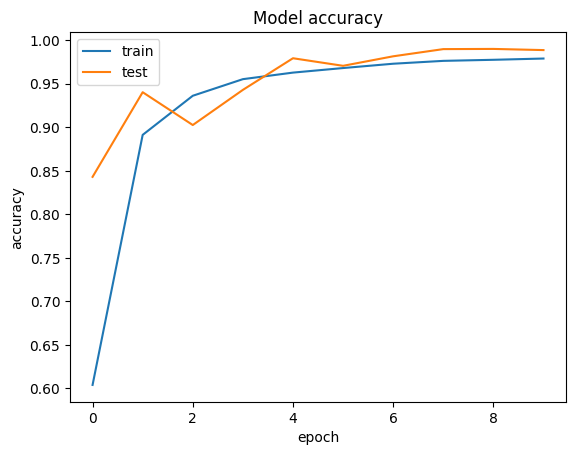

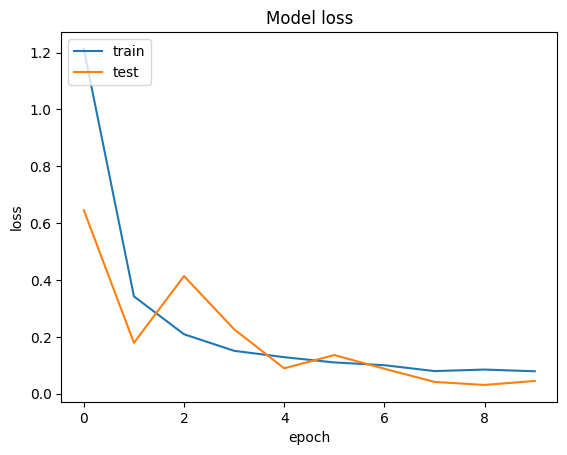

In [87]:
def plot_train_history(history):
    
    ## Plot the validation accuracy and validation loss over epochs
    
    
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history)

### Prediction on test set

In [88]:
def plot_test_class(model, test_files, image_number, color_type=3):
    
    ## Function that tests or model on test images and show the results
    
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=0)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [89]:
score1 = model.evaluate(x_test, y_test, verbose=1)


141/141 [==============================] - 5s 37ms/step - loss: 0.0452 - accuracy: 0.9886


In [90]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.045165054500103
Accuracy:  98.86287450790405  %


Y prediction: [[3.1064863e-21 6.9648459e-31 6.7042762e-20 2.9126657e-23 2.2957208e-23
  1.0000000e+00 1.4112651e-22 9.3081125e-19 1.6717262e-19 1.8500892e-16]]
Predicted: Operating the radio


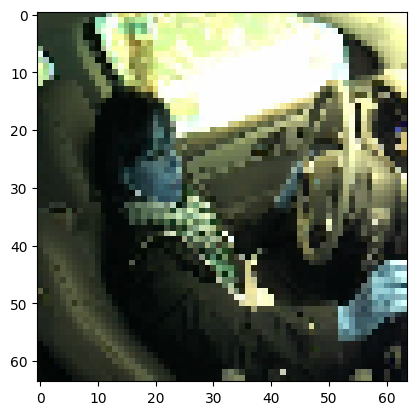

Y prediction: [[1.7432112e-15 1.7694208e-22 5.7749764e-19 2.8673234e-15 1.1422661e-16
  1.0000000e+00 1.7950354e-17 4.9632923e-16 1.4699686e-14 7.8671736e-14]]
Predicted: Operating the radio


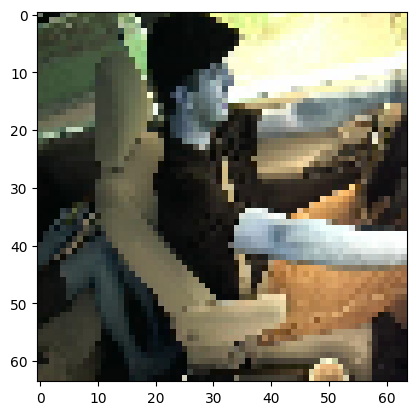

Y prediction: [[9.9886000e-01 2.5273699e-04 4.0593417e-04 4.5965172e-04 1.1517701e-06
  3.8578012e-08 3.7387577e-09 9.7502325e-06 8.7899785e-08 1.0621827e-05]]
Predicted: Safe driving


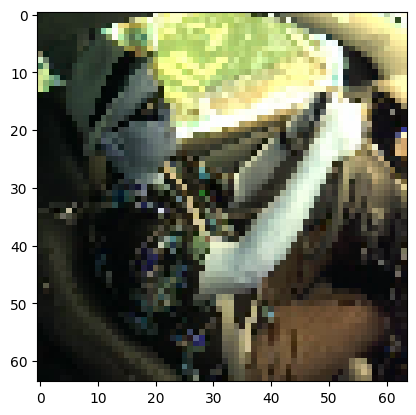

Y prediction: [[3.2051020e-12 6.6051544e-12 3.9577813e-04 5.6774137e-17 2.8588481e-13
  2.0828703e-14 1.6390074e-04 6.1432914e-10 9.9944025e-01 6.1276011e-09]]
Predicted: Hair and makeup


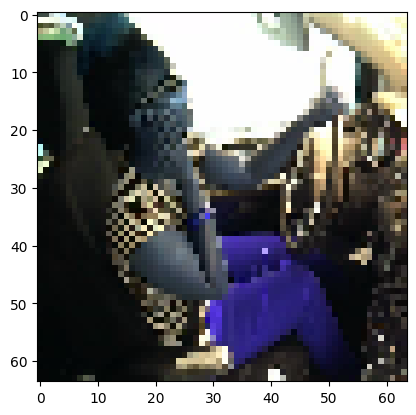

Y prediction: [[8.20367404e-07 2.95648347e-17 1.12149465e-11 2.24891747e-03
  9.97715712e-01 1.52411476e-05 1.14447660e-10 1.86501517e-13
  1.82392650e-05 9.73996748e-07]]
Predicted: Talking on the phone - left


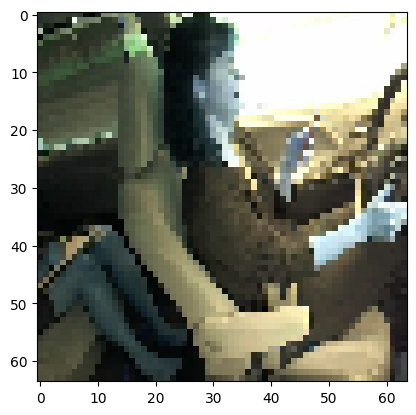

Y prediction: [[9.2971091e-12 2.3460819e-08 1.8507325e-15 1.0000000e+00 2.4500896e-10
  2.1330233e-10 2.3950373e-13 4.4157476e-13 2.9166734e-12 2.5006689e-13]]
Predicted: Texting - left


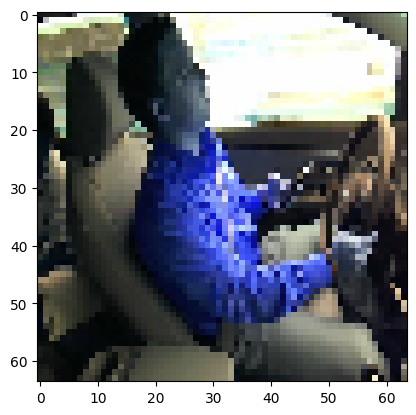

Y prediction: [[2.3608541e-08 1.1370638e-07 7.7388718e-09 8.5552267e-07 1.9752008e-10
  2.4387696e-09 1.2036141e-08 3.3364959e-08 9.9985659e-01 1.4232377e-04]]
Predicted: Hair and makeup


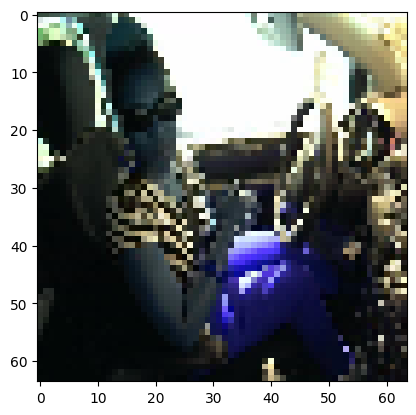

Y prediction: [[2.7920560e-03 3.4346620e-08 8.0420210e-07 4.2791326e-02 3.3280122e-01
  2.2727920e-06 3.8739087e-09 5.3828657e-01 1.3810814e-04 8.3187647e-02]]
Predicted: Reaching behind


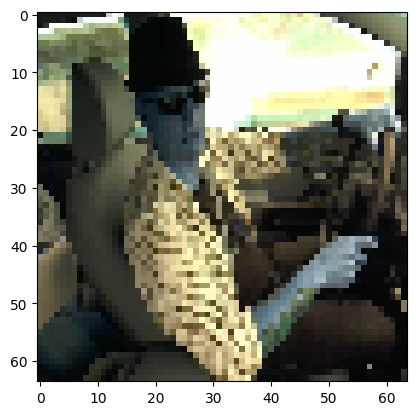

Y prediction: [[8.9590323e-12 5.7133065e-10 3.6948622e-04 9.7502200e-15 4.4207280e-08
  2.2078128e-09 9.9962950e-01 1.9351510e-13 9.0433514e-07 2.7199620e-14]]
Predicted: Drinking


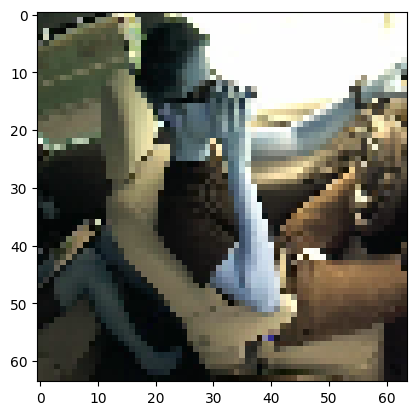

Y prediction: [[7.03455488e-11 2.59256863e-13 3.57544940e-13 4.72639451e-13
  2.86330448e-09 1.50589469e-12 1.68986990e-13 1.00000000e+00
  1.10152706e-10 5.34161040e-12]]
Predicted: Reaching behind


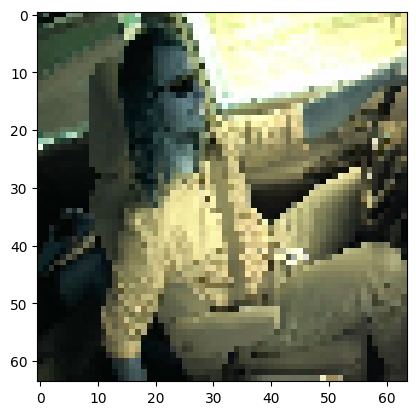

In [91]:
for i in range(10):
    plot_test_class(model, test_files, i)

<div id="overview">
        <h1 style="color:#1a1a1a">
         ⮞  Part 4 : Data Augmentation
        </h1>
</div>

In [92]:
# Using ImageDataGenerator from keras
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2) # with augmentation

test_datagen = ImageDataGenerator(rescale = 1.0 / 255, validation_split = 0.2) # without augmentation


# rescale :- dividing the pixel values by 255, which normalizes the pixel values to be in the range of 0 to 1
# horizontal_flip :- performs random horizontal flips
# shear_range :- introduces shearing transformations to the images
# zoom_range :- applies random zooms

In [93]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
training_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size = batch_size)

### Training with data augmentation

In [94]:
history_v2 = model.fit(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = n_epochs, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
448/448 [==============================] - 114s 251ms/step - loss: 1.1321 - accuracy: 0.6794 - val_loss: 2.3035 - val_accuracy: 0.0871
Epoch 2/10
448/448 [==============================] - 103s 230ms/step - loss: 0.5504 - accuracy: 0.8236 - val_loss: 1.0082 - val_accuracy: 0.6882
Epoch 3/10
448/448 [==============================] - 101s 225ms/step - loss: 0.4153 - accuracy: 0.8732 - val_loss: 0.1267 - val_accuracy: 0.9759
Epoch 4/10
448/448 [==============================] - 99s 222ms/step - loss: 0.3541 - accuracy: 0.8931 - val_loss: 0.0986 - val_accuracy: 0.9763
Epoch 5/10
448/448 [==============================] - 105s 234ms/step - loss: 0.3132 - accuracy: 0.9064 - val_loss: 0.0807 - val_accuracy: 0.9812
Epoch 6/10
448/448 [==============================] - 99s 220ms/step - loss: 0.2770 - accuracy: 0.9190 - val_loss: 0.1018 - val_accuracy: 0.9754
Epoch 7/10
448/448 [==============================] - 97s 217ms/step - loss: 0.2620 - accuracy: 0.9225 - val_loss: 0.0911 - va

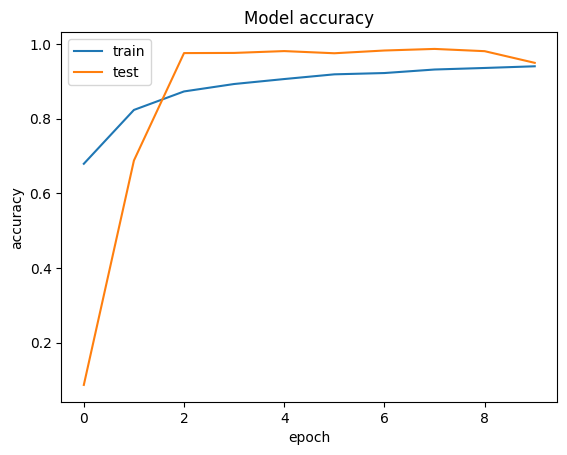

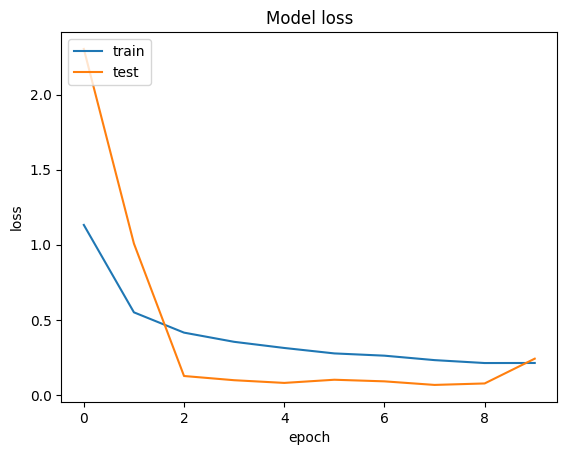

In [95]:
plot_train_history(history_v2)


In [97]:
# Evaluate and compare the performance of the new model
score2 = model.evaluate(validation_generator)
print("Loss for model 1",score1[0])
print("Loss for model 2 (data augmentation):", score2[0])

print("Test accuracy for model 1",score1[1])
print("Test accuracy for model 2 (data augmentation):", score2[1])

113/113 [==============================] - 5s 43ms/step - loss: 0.2428 - accuracy: 0.9496
Loss for model 1 0.045165054500103
Loss for model 2 (data augmentation): 0.2428281456232071
Test accuracy for model 1 0.9886287450790405
Test accuracy for model 2 (data augmentation): 0.9496098160743713


# Part 5 : Transfer Learning with VGG 

In [98]:
from keras.applications.vgg16 import VGG16

In [99]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    
    ## Architecture and adaptation of the VGG16 for our project
    
    nb_classes = 10
    
    # Remove fully connected layer and replace
    
    vgg16_model = VGG16(weights="imagenet", include_top=False) # exclude the fully connected layers at the top of the network
    
    # sets all the layers in the model to be non-trainable
    for layer in vgg16_model.layers:
        layer.trainable = False
    
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)
    
    predictions = Dense(nb_classes, activation = 'softmax')(x) # add dense layer with 10 neurons and activation softmax
    model = Model(vgg16_model.input,predictions)
    return model

In [100]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)
model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None

In [101]:
training_generator = train_datagen.flow_from_directory('state-farm-distracted-driver-detection/imgs/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('state-farm-distracted-driver-detection/imgs/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [102]:
epoch = 10

In [103]:
# Training the new Model
# checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', 
# monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_vgg16.fit(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = epoch, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
448/448 [==============================] - 138s 306ms/step - loss: 1.6877 - accuracy: 0.4027 - val_loss: 1.4756 - val_accuracy: 0.4603
Epoch 2/10
448/448 [==============================] - 141s 314ms/step - loss: 1.2162 - accuracy: 0.5734 - val_loss: 1.0175 - val_accuracy: 0.6346
Epoch 3/10
448/448 [==============================] - 135s 302ms/step - loss: 0.9951 - accuracy: 0.6563 - val_loss: 0.7694 - val_accuracy: 0.7446
Epoch 4/10
448/448 [==============================] - 128s 287ms/step - loss: 0.8587 - accuracy: 0.7063 - val_loss: 0.8192 - val_accuracy: 0.7036
Epoch 5/10
448/448 [==============================] - 121s 270ms/step - loss: 0.7488 - accuracy: 0.7447 - val_loss: 0.8061 - val_accuracy: 0.7196
Epoch 6/10
448/448 [==============================] - 125s 279ms/step - loss: 0.6712 - accuracy: 0.7736 - val_loss: 0.7365 - val_accuracy: 0.7522
Epoch 7/10
448/448 [==============================] - 139s 310ms/step - loss: 0.6046 - accuracy: 0.7994 - val_loss: 0.6200 -

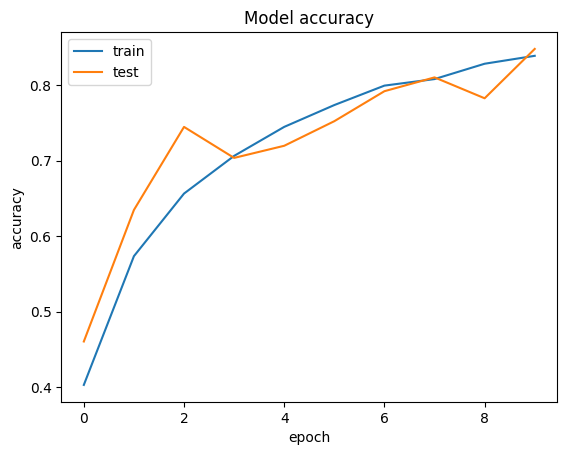

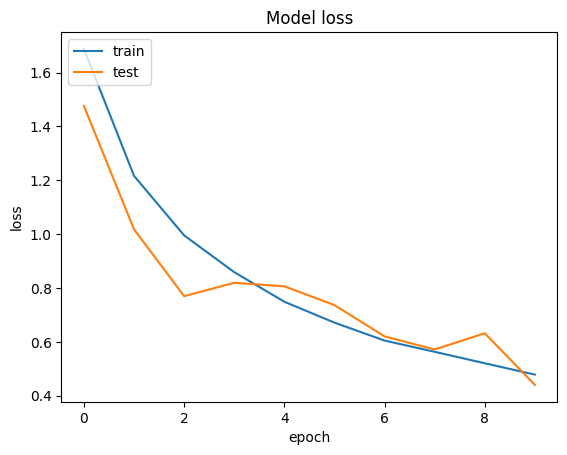

In [104]:
plot_train_history(history_v3)

In [105]:
# Evaluate the performance of the new model with Transfer learning
score3 = model_vgg16.evaluate(validation_generator, verbose = 1)

print("Test Score with simple CNN:", score1[0])
print("Test Accuracy with simple CNN", score1[1])
print('--------------------------------------')
print("Test Score with Data Augmentation:", score2[0])
print("Test Accuracy with Data Augmentation:", score2[1])
print('--------------------------------------')
print("Test Score with Transfer Learning:", score3[0])
print("Test Accuracy with Transfer Learning:", score3[1])

113/113 [==============================] - 23s 202ms/step - loss: 0.4398 - accuracy: 0.8480
Test Score with simple CNN: 0.045165054500103
Test Accuracy with simple CNN 0.9886287450790405
--------------------------------------
Test Score with Data Augmentation: 0.2428281456232071
Test Accuracy with Data Augmentation: 0.9496098160743713
--------------------------------------
Test Score with Transfer Learning: 0.43978509306907654
Test Accuracy with Transfer Learning: 0.8480250239372253
